In [26]:
import numpy as np
import matplotlib.pyplot as plt
from reactionmodel.model import Species, Reaction, Model

In [85]:
Z = Species('Z')
Y = Species('Y')

b = Species('b')


reactivation = Reaction([Z], [Y], k='a')
birth = Reaction([Y], [(Y, 2)], k='lam')

background_birth = Reaction([b], [(b, 2)], k=1.0)
background_death = Reaction([b], [], k=1.0)


m = Model([Z,Y,b], [reactivation, birth, background_birth, background_death])

m = Model([Z,Y], [reactivation, birth])


parameters = {
    'a': 1e-5,
    'lam': 1.0
}

ic = {'Y': 0, 'Z':1000, 'b':10000}
ic = {'Y': 0, 'Z':1e7}

# Conventional $\tau$-leaping

In [86]:
from hybrid.tau import TauLeapSimulator

tau_simulator = TauLeapSimulator(
    m.get_k(parameters=parameters),
    m.stoichiometry(),
    m.kinetic_order(),
    species_creation_is_critical=False,
    only_reactants_critical=True
)

Evaluating expression: a => 1e-05
Evaluating expression: lam => 1.0


In [91]:
def halt_on_any_Y(t, x):
    if x[m.species_name_index['Y']] > 0:
        return True
    return False

results = tau_simulator.run_simulations(100, [0.0, 2.0], m.make_initial_condition(ic), np.random.default_rng(), halt=halt_on_any_Y)
#results = tau_simulator.run_simulations(50, [0.0, 10.0], m.make_initial_condition(ic), np.random.default_rng(), halt=halt_on_any_Y, end_routine=lambda r: r.t)

In [92]:
results[0].status_counter

Counter({<TauStepStatus.stochastic: 4>: 578,
         <TauStepStatus.rejected_for_gillespie: -2>: 6,
         <TauStepStatus.t_end: 0>: 1})

(array([19., 10., 14., 12.,  6.,  4.,  5.,  0.,  3.,  3.,  1.,  2.,  2.,
         2.,  5.,  4.,  0.,  1.,  1.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.]),
 array([0.00018499, 0.00187606, 0.00356713, 0.0052582 , 0.00694927,
        0.00864033, 0.0103314 , 0.01202247, 0.01371354, 0.0154046 ,
        0.01709567, 0.01878674, 0.02047781, 0.02216888, 0.02385994,
        0.02555101, 0.02724208, 0.02893315, 0.03062421, 0.03231528,
        0.03400635, 0.03569742, 0.03738848, 0.03907955, 0.04077062,
        0.04246169, 0.04415276, 0.04584382, 0.04753489, 0.04922596,
        0.05091703]),
 <BarContainer object of 30 artists>)

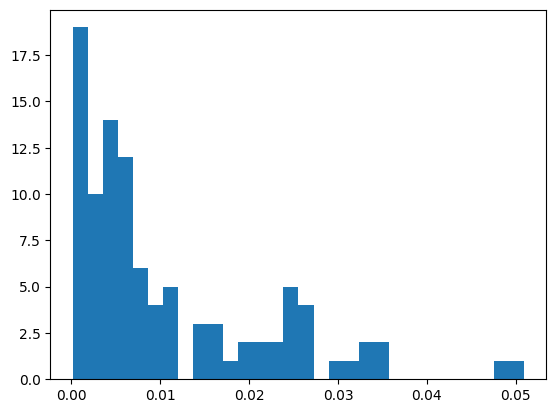

In [90]:
ts = [r.t for r in results]
plt.hist(ts, bins=30)

TypeError: '<=' not supported between instances of 'History' and 'History'

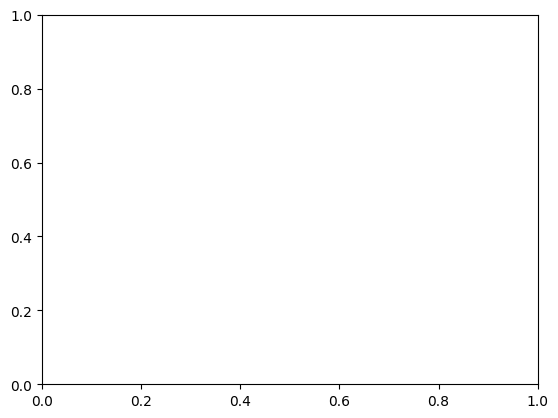

In [65]:
plt.hist(results, bins=30)

In [31]:
#ax = results[0].plot(m.legend())
#ax.set_yscale('log')

# Critical products $\tau$-leaping

In [32]:
from hybrid.tau import TauLeapSimulator

critical_tau_simulator = TauLeapSimulator(
    m.get_k(parameters=parameters),
    m.stoichiometry(),
    m.kinetic_order(),
    species_creation_is_critical=True,
    only_reactants_critical=False
)

Evaluating expression: a => 0.001
Evaluating expression: lam => 1.0


In [33]:
critical_results = critical_tau_simulator.run_simulations(5000, [0.0, 10.0], m.make_initial_condition(ic), np.random.default_rng(), halt=halt_on_any_Y, end_routine=lambda r: r.t)

/Users/thayer/develop/hybrid/hybrid/tau.py:315: RuntimeWarning: divide by zero encountered in divide
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))


(array([1.353e+03, 1.025e+03, 7.650e+02, 4.970e+02, 3.940e+02, 2.650e+02,
        1.810e+02, 1.550e+02, 1.060e+02, 6.900e+01, 4.900e+01, 4.600e+01,
        2.300e+01, 2.300e+01, 1.400e+01, 7.000e+00, 1.000e+01, 5.000e+00,
        5.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([8.11876723e-05, 3.23346498e-01, 6.46611808e-01, 9.69877118e-01,
        1.29314243e+00, 1.61640774e+00, 1.93967305e+00, 2.26293836e+00,
        2.58620367e+00, 2.90946898e+00, 3.23273429e+00, 3.55599960e+00,
        3.87926491e+00, 4.20253022e+00, 4.52579553e+00, 4.84906084e+00,
        5.17232615e+00, 5.49559146e+00, 5.81885677e+00, 6.14212208e+00,
        6.46538739e+00, 6.78865270e+00, 7.11191801e+00, 7.43518332e+00,
        7.75844863e+00, 8.08171394e+00, 8.40497925e+00, 8.72824456e+00,
        9.05150987e+00, 9.37477518e+00, 9.69804049e+00]),
 <BarContainer object of 30 artists>)

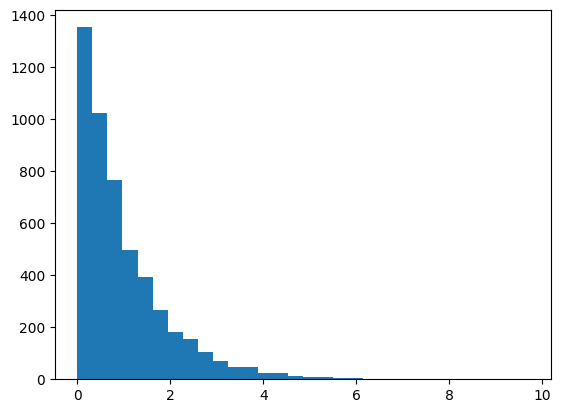

In [34]:
plt.hist(critical_results, bins=30)

Text(0.5, 1.0, '')

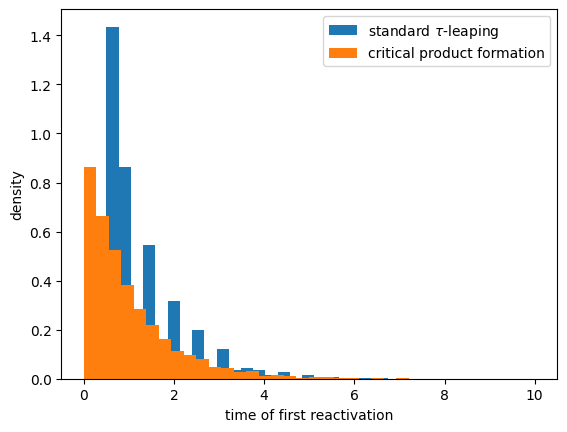

In [41]:
fig, ax = plt.subplots()

ax.hist(results, bins=35, density=True)
ax.hist(critical_results, bins=35, density=True)
ax.legend(['standard $\\tau$-leaping', 'critical product formation'])
plt.ylabel('density')
plt.xlabel('time of first reactivation')

plt.title("")

# Comparing trajectories

In [43]:
trajectories = tau_simulator.run_simulations(100, [0.0, 10.0], m.make_initial_condition(ic), np.random.default_rng())
critical_trajectories = critical_tau_simulator.run_simulations(100, [0.0, 10.0], m.make_initial_condition(ic), np.random.default_rng())

/Users/thayer/develop/hybrid/hybrid/tau.py:315: RuntimeWarning: divide by zero encountered in divide
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))


(array([ 1.,  0.,  5.,  3.,  2.,  9., 18., 29., 25.,  8.]),
 array([ 3.40119738,  4.20019636,  4.99919533,  5.7981943 ,  6.59719328,
         7.39619225,  8.19519122,  8.9941902 ,  9.79318917, 10.59218814,
        11.39118712]),
 <BarContainer object of 10 artists>)

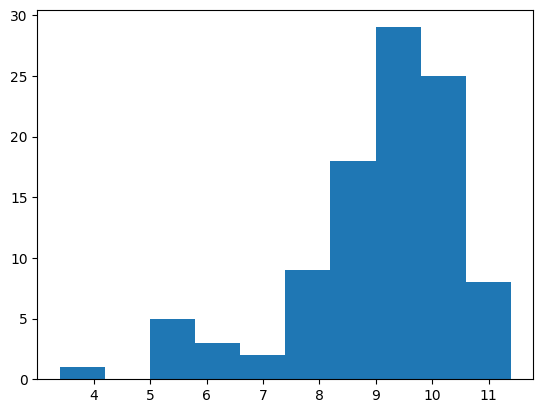

In [47]:
plt.hist(np.log(np.array([trj.y[m.species_name_index['Y']] for trj in trajectories])))

(array([ 1.,  1.,  1.,  4.,  7., 19., 18., 26., 15.,  8.]),
 array([ 5.3082677 ,  5.93034541,  6.55242313,  7.17450084,  7.79657856,
         8.41865627,  9.04073399,  9.6628117 , 10.28488942, 10.90696713,
        11.52904485]),
 <BarContainer object of 10 artists>)

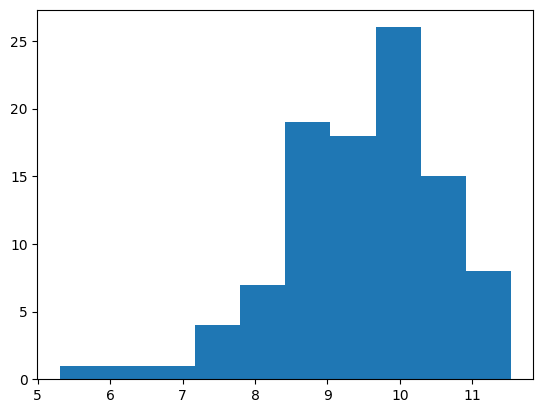

In [48]:
plt.hist(np.log(np.array([trj.y[m.species_name_index['Y']] for trj in critical_trajectories])))